In [1]:
import warnings

warnings.filterwarnings('ignore')

## Installing Necessary Libraries

In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 31.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting 

## Loading Data

In [3]:
# Loading Dataset from the Github
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/vishesh-kumar-singh/Senntiment-Analysis-from-IMDB-Movie-Review/refs/heads/main/IMDB%20Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info()     # Checking basic information about the data
df.isnull().sum()    # Checking for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,0
review,0
sentiment,0


In [6]:
df['sentiment'].value_counts()    # Checking for any imbalance in Data

,count
sentiment,
positive,25000
negative,25000


In [7]:
def labeler(value):     # Defined a function to enceode the sentiments from positive and negetive to binary
    if value=="positive":
        return 1
    else:
        return 0
df["label"]=df['sentiment'].apply(labeler)        #applying the labeling function to dataset

In [8]:
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


## Dataset Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

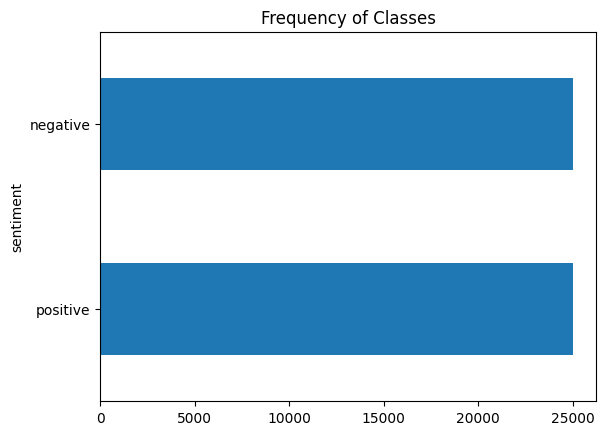

In [10]:
# Plotting The frequency of Classes (Although it was not necessary since it is already known that the dataset is balanced)

label_counts = df['sentiment'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per Review'}, xlabel='sentiment'>

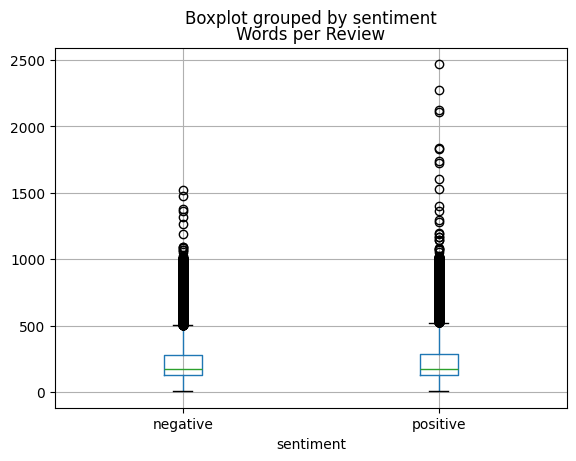

In [11]:
df['Words per Review'] = df['review'].str.split().apply(len)          # Checking words per review in the dataset.
df.boxplot("Words per Review", by="sentiment")                # Uning Box plot to clearly visualise the distributuion and outliers

## Text to Token Conversion

In [12]:
from transformers import AutoTokenizer

In [13]:
# Due to hardware insufficiency distilbert-base-uncased model is used which is a lighter and faster version of bert

model_ckpt = "distilbert-base-uncased"                  # For case insensitivity 
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
tokenizer.vocab_size, tokenizer.model_max_length    # Checking the vocabulary size of the model and the max input length

(30522, 512)

## Data Loader and Train Test Split

In [15]:
# Train, Test and Validation split 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['sentiment'])
train.shape, test.shape, validation.shape

((35000, 4), (10000, 4), (5000, 4))

In [16]:
# Creating dataset dictionary to get everything in a single object
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'label', 'Words per Review'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'label', 'Words per Review'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'label', 'Words per Review'],
        num_rows: 5000
    })
})

## Tokenization of emotion/sentiment data

In [17]:
dataset['train'][0]        # This shows a sample element from our train subset in the dataset

{'review': "The saddest part of this is the fact that these are 87 minutes I'll never get back. I knew this was terrible from the get-go, with the guy dressed as a lunatic Indian chief on top of the roof. (See if they could get away with that in 2008). My 10-year-old boy is really into baseball right now, so we decided to rent it on a rainy day. Even though he seemed to enjoy parts of it, I had to cringe when I heard all the needless foul language. Bad, bad movie. This was an awful ripoff of Bad News Bears. Completely shameless and completely predictable. I don't mind a predictable movie if it's done well, but this one absolutely was not.",
 'sentiment': 'negative',
 'label': 0,
 'Words per Review': 122}

In [18]:
def tokenize(batch):           # Function for Tokenising the whole dataset
    temp= tokenizer(batch['review'], padding=True, truncation=True, return_token_type_ids=True,)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1996, 6517, 6155, 2102, 2112, 1997, 2023, 2003, 1996, 2755, 2008, 2122, 2024, 6584, 2781, 1045, 1005, 2222, 2196, 2131, 2067, 1012, 1045, 2354, 2023, 2001, 6659, 2013, 1996, 2131, 1011, 2175, 1010, 2007, 1996, 3124, 5102, 2004, 1037, 26594, 2796, 2708, 2006, 2327, 1997, 1996, 4412, 1012, 1006, 2156, 2065, 2027, 2071, 2131, 2185, 2007, 2008, 1999, 2263, 1007, 1012, 2026, 2184, 1011, 2095, 1011, 2214, 2879, 2003, 2428, 2046, 3598, 2157, 2085, 1010, 2061, 2057, 2787, 2000, 9278, 2009, 2006, 1037, 16373, 2154, 1012, 2130, 2295, 2002, 2790, 2000, 5959, 3033, 1997, 2009, 1010, 1045, 2018, 2000, 13675, 23496, 2043, 1045, 2657, 2035, 1996, 17044, 2015, 12487, 2653, 1012, 2919, 1010, 2919, 3185, 1012, 2023, 2001, 2019, 9643, 10973, 7245, 1997, 2919, 2739, 6468, 1012, 3294, 9467, 3238, 1998, 3294, 21425, 1012, 1045, 2123, 1005, 1056, 2568, 1037, 21425, 3185, 2065, 2009, 1005, 1055, 2589, 2092, 1010, 2021, 2023, 2028, 7078, 2001, 2025, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
emotion_encoded=dataset.map(tokenize, batched=True, batch_size=None)         # Applying Tokenisation to the whole Dataset

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [20]:
# Defining dictonaries for easy converstion from sentiments to the label alloted to them

label2id = {x['sentiment']:x['label'] for x in dataset ['train']}
id2label = {v:k for k,v in label2id.items()}
label2id, id2label

({'negative': 0, 'positive': 1}, {0: 'negative', 1: 'positive'})

## Model Building

In [21]:
# Importing Modules
from transformers import AutoModel
import torch

In [22]:
from transformers import AutoModelForSequenceClassification, AutoConfig
Num_labels = len(label2id)

device = torch.device ("cuda" if torch. cuda.is_available() else "cpu")            # Selecting to use GPU if avialable
print(device)

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)         # Using configurations from pre-Trained Checkpoint  
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)         # Loading the model

cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [24]:
from transformers import Trainer
from transformers import TrainingArguments

In [25]:


batch_size=64

# Defining Training Directory and Training Arguments
training_dir = "bert_base_training_dir"
training_args= TrainingArguments(output_dir = training_dir,
        overwrite_output_dir = True,
        num_train_epochs = 2,
        learning_rate = 2e-5,
        per_device_train_batch_size = batch_size,
        per_device_eval_batch_size = batch_size,
        weight_decay = 0.01,
        evaluation_strategy = 'epoch',
        disable_tqdm = False,
        logging_dir = './logs',
        logging_strategy = 'steps',
        logging_steps = 10,
        log_level = 'debug'
    )

# Build Model and Trainer

In [26]:
from sklearn.metrics import accuracy_score, f1_score

# Function for evaluation
def compute_metrics (pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [27]:
# Building Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [28]:
# Initiating training
trainer.train()

Currently training with a batch size of: 64
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Words per Review, token_type_ids, sentiment, review. If Words per Review, token_type_ids, sentiment, review are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 35,000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1,094
  Number of trainable parameters = 66,955,010
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.r

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.176600,0.199467,0.923600,0.923538
2,0.131700,0.189176,0.930800,0.930800


Saving model checkpoint to bert_base_training_dir/checkpoint-500
Configuration saved in bert_base_training_dir/checkpoint-500/config.json
Model weights saved in bert_base_training_dir/checkpoint-500/model.safetensors
tokenizer config file saved in bert_base_training_dir/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert_base_training_dir/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Words per Review, token_type_ids, sentiment, review. If Words per Review, token_type_ids, sentiment, review are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 5000
  Batch size = 64
Saving model checkpoint to bert_base_training_dir/checkpoint-1000
Configuration saved in bert_base_training_dir/checkpoint-1000/config.json
Model weights saved in be

TrainOutput(global_step=1094, training_loss=0.19779205943374356, metrics={'train_runtime': 3390.4429, 'train_samples_per_second': 20.646, 'train_steps_per_second': 0.323, 'total_flos': 9272717905920000.0, 'train_loss': 0.19779205943374356, 'epoch': 2.0})

In [30]:
preds_output = trainer.predict(emotion_encoded[ 'test'])
preds_output.metrics

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Words per Review, token_type_ids, sentiment, review. If Words per Review, token_type_ids, sentiment, review are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 10000
  Batch size = 64


{'test_loss': 0.19644659757614136,
 'test_accuracy': 0.928,
 'test_f1': 0.9279995132767097,
 'test_runtime': 154.0537,
 'test_samples_per_second': 64.912,
 'test_steps_per_second': 1.019}

In [31]:
preds_output.predictions

array([[ 2.2192004 , -2.5705357 ],
       [ 0.7004831 , -0.6920902 ],
       [-0.98788875,  1.0137002 ],
       ...,
       [-2.4555914 ,  2.6388013 ],
       [-1.5882726 ,  1.7674009 ],
       [ 2.7586396 , -3.0896537 ]], dtype=float32)

In [32]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = [label2id[sentiment] for sentiment in emotion_encoded['test'][:]['sentiment']]

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5000
           1       0.93      0.93      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



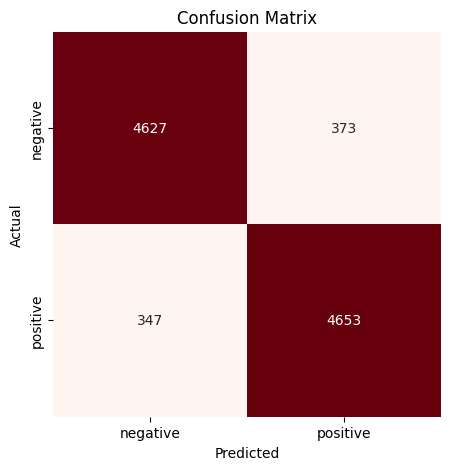

In [35]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt ='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.show()

## Building Prediction function and Saving model

In [37]:
text = "The perfect example of how you can make a bad movie with a good story"      # A sample text

# Defining Function
def get_prediction (text) :
    input_encoded = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
      outputs = model(**input_encoded)
    logits = outputs. logits
    pred = torch.argmax(logits, dim=1) .item()
    return id2label[pred]
get_prediction (text)

'negative'

In [40]:
# Saving Model
trainer.save_model("distilbert-base-uncased-sentiment-model")

Saving model checkpoint to distilbert-base-uncased-sentiment-model
Configuration saved in distilbert-base-uncased-sentiment-model/config.json
Model weights saved in distilbert-base-uncased-sentiment-model/model.safetensors
tokenizer config file saved in distilbert-base-uncased-sentiment-model/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-sentiment-model/special_tokens_map.json


In [41]:
# Using pipeline for prediciton
from transformers import pipeline
classifier = pipeline('text-classification', model= 'distilbert-base-uncased-sentiment-model')
classifier([text, 'The storyline is not good. There are many scenes that are included with no specific reason like the starting when Pushpa is in Japan and fights people there and the scene goes on for like 10 minutes, only for him to wake up (it was just a dream...). It also shows Pushpa is scared of water there because of a past experience. But that scene too has no relevance to any other part of the story whatsoever.The only thing good about this movie was the action scenes which has impressive camera angles and dramatic effects although the fights were overexaggerated (gets a pass because South Indian film)'])

loading configuration file distilbert-base-uncased-sentiment-model/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-sentiment-model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.48.0",
  "vocab_size": 30522
}

loading configuration file distilbert-base-uncased-sentiment-model/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbe

[{'label': 'negative', 'score': 0.5012853145599365},
 {'label': 'negative', 'score': 0.9921901822090149}]

In [42]:
# Saving the Model to Google Drive

from google.colab import drive
drive.mount('/content/drive')

model_save_path = "/content/drive/MyDrive/distilbert-base-uncased-sentiment-model"
trainer.save_model(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/distilbert-base-uncased-sentiment-model
Configuration saved in /content/drive/MyDrive/distilbert-base-uncased-sentiment-model/config.json


Mounted at /content/drive


Model weights saved in /content/drive/MyDrive/distilbert-base-uncased-sentiment-model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/distilbert-base-uncased-sentiment-model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/distilbert-base-uncased-sentiment-model/special_tokens_map.json
